# Shared virtual memory (SVM)

Shared Virtual Memory (SVM) is a way to blur or even erase the boundary between host memory and global device memory. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces_svm.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads. In shared virtual memory implementations the boundary between global and host memory is removed to varying degrees.</figcaption>
</figure>

Sometimes algorithms can benefit when both host and device share access to the same memory. This may give the compute device access to larger memory allocations on the host. Compute device architectures such as System On Chip (SOC), where an integrated GPU uses host memory, is served well by SVM. Shared Virtual Memory is only available on OpenCL 2.0+ implementations, and optionally available on OpenCL 3.0+ implementations.

## Types of shared virtual memory

There are three main types of shared virtual memory (SVM):

* Coarse-grained buffer SVM
* Fine-grained buffer SVM
* Fine-grained system SVM

**Coarse-grained buffer SVM** is the most basic level of SVM support and the only one that is technically required by the OpenCL 2.0 standard. Coarse-grained buffer SVM doesn't appear much different from standard OpenCL buffers. The only difference I can see is that it enables one to allocate and de-allocate memory on the host using special SVM functions [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) and [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html), and then the ability to use the allocated pointer in a kernel invocation instead of an OpenCL buffer. There may be synchronisation between host and device, however the allocation must still be mapped back to the host for host access and then un-mapped when host access is no longer required.

**Fine-grained buffer SVM** removes the requirement to map and unmap memory, but it still needs the special SVM functions [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) and [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html) to allocate and de-allocate shared memory. At runtime the code must notify the kernel of any SVM pointers that are to be used, either directly as kernel arguments or indirectly used (i.e through pointers in data structures accessed by the kernel). This can be rather painful. Unlike coarse-grained SVM, both host and device can access the allocation at the **same time**. Consistency between host and device is guaranteed if host and device are accessing different bytes in the allocation. If there is a need for host and device to read what the other has written, then memory can be explicitly synchronised by waiting for enqueued commands to finish. If host and device must read and update the **same bytes in the allocation**, then atomic data types (if supported) and special synchronisation functions can be used to maintain coherency.

**Fine-grained system SVM** further removes the requirement to use [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) and [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html) to allocate and de-allocate shared memory. System functions (such as **malloc**) allocate memory on the host, and the associated pointer is available for use in kernels. Only pointers directly used by the kernel must be passed in as kernel arguments. Pointers used indirectly can be accessed without having to notify the kernel of their existence. As with fine-grained buffer SVM, if host and device must read and update the **same bytes in the allocation**, then atomic data types (if supported) and special synchronisation functions can be used to maintain coherency.


### Checking to see what kind of shared virtual memory your system supports

The OpenCL function [clGetDeviceInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetDeviceInfo.html) can query the SVM capabilities of the compute device. In the file [svm_check.cpp](svm_check.cpp) we use [clGetDeviceInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetDeviceInfo.html) along with the key **CL_DEVICE_SVM_CAPABILITIES** to get a return code. The key **CL_DEVICE_SVM_CAPABILITIES** is only available with OpenCL 2.0+ implementations so the following code will not even compile with an older OpenCL implementation.

```C++
    // Check if the device supports coarse-grained SVM
    cl_device_svm_capabilities svm;
    errcode = clGetDeviceInfo(
        device,
        CL_DEVICE_SVM_CAPABILITIES,
        sizeof(cl_device_svm_capabilities),
        &svm,
        NULL
    );
```

The error code may then be evaluated to see what SVM implementations are available:

```C++
    if (errcode == CL_INVALID_VALUE) { 
        printf("Sorry, this device does not support Shared Virtual Memory.");
        exit(OCL_EXIT);
    }    
    
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_COARSE_GRAIN_BUFFER)) {
        printf("Device supports coarse-grained SVM\n");
    }
        
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_FINE_GRAIN_BUFFER)) {
        printf("Device supports fine-grained buffer SVM\n");
    }
 
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_FINE_GRAIN_BUFFER) &&
        (svm & CL_DEVICE_SVM_ATOMICS)) {
        printf("Device supports fine-grained buffer SVM with atomics\n");
    }
    
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_FINE_GRAIN_SYSTEM)) {
        printf("Device supports fine-grained system SVM\n");
    }
 
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_FINE_GRAIN_SYSTEM) && 
        (svm & CL_DEVICE_SVM_ATOMICS)) {
        printf("Device supports fine-grained buffer SVM with atomics\n");
    }
```

Alternatively, the **clinfo** command is able to inspect what SVM implementations are available for each device. It is interesting to note that at the time of writing the Intel OpenCL implementation has all forms of shared virtual memory available. The NVIDIA implementation only has coarse-grained SVM, and AMD has both coarse-grained and fine-grained SVM but no support for atomics.

In [3]:
!clinfo

Number of platforms                               4
  Platform Name                                   Intel(R) FPGA Emulation Platform for OpenCL(TM)
  Platform Vendor                                 Intel(R) Corporation
  Platform Version                                OpenCL 1.2 Intel(R) FPGA SDK for OpenCL(TM), Version 20.3
  Platform Profile                                EMBEDDED_PROFILE
  Platform Extensions                             cl_khr_spirv_linkonce_odr cl_khr_icd cl_khr_byte_addressable_store cl_intel_fpga_host_pipe cles_khr_int64 cl_khr_il_program cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics 
  Platform Extensions function suffix             IntelFPGA

  Platform Name                                   Intel(R) OpenCL
  Platform Vendor                                 Intel(R) Corporation
  Platform Version                                OpenCL 3.0 LINUX
  Platform Profile        

### Coarse-grained SVM example

For coarse-grained SVM we still have the restriction of having to map a memory space back to the host. The application [mat_mult_coarse_buffer_svm.cpp](mat_mult_coarse_buffer_svm.cpp) uses the standard matrix multiplication kernel. 

#### Direct use of SVM pointers

We use [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html) to  allocate Matrix C from coarse-grained shared virtual memory.

```C++
    // mat_mult_coarse_buffer_svm.cpp:119

    // Allocate coarse-grained SVM memory for array C
    cl_float *array_C = (cl_float*)clSVMAlloc(
        context,
        CL_MEM_WRITE_ONLY,
        nbytes_C,
        0
    );
```

At kernel runtime we then use a different function [clSetKernelArgSVMPointer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSetKernelArgSVMPointer.html) to set the kernel argument.

```C++
    // mat_mult_coarse_buffer_svm.cpp:175
    h_errchk(
        clSetKernelArgSVMPointer(
            kernel, 2, array_C
        ),
        "setting kernel argument 2"
    );
```

As before, the memory in matrix C is used in the [kernel](kernels_mat_mult.c) as part of the **global** memory address space.

```C++
// kernels_mat_mult.c:28 source

// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) {
    ...
```

In order to use the allocation from the host it must be mapped. Here we map **array_C** back to the host with [clEnqueueSVMMap](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueSVMMap.html), write the memory to storage, and unmap with [clEnqueueSVMUnmap](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueSVMUnmap.html).

```C++
    // mat_mult_coarse_buffer_svm.cpp:265

    // Map the SVM array
    h_errchk(
        clEnqueueSVMMap(
            command_queue,
            CL_TRUE,
            CL_MAP_READ,
            array_C,
            nbytes_C,
            0,
            NULL,
            NULL
        ),
        "Map the SVM array."
    );
    
    // Write out the result to file
    h_write_binary(array_C, "array_C.dat", nbytes_C);

    // Unmap the SVM array
    h_errchk(
        clEnqueueSVMUnmap(
            command_queue,
            array_C,
            0,
            NULL,
            NULL
        ),
        "Unmap the SVM array."
    );
```

Now that the memory is unmapped we can use either [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html) or [clEnqueueSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueSVMFree.html) to free the allocation. It might be preferred to use [clEnqueueSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueSVMFree.html) because then you can be sure the command queue is empty before freeing memory.

```C++
    // mat_mult_coarse_buffer_svm.cpp:306

    // Enqueue a free of the SVM buffer
    h_errchk(
        clEnqueueSVMFree(
            command_queue,
            1,
            (void**)((void*)(&array_C)),
            NULL,
            NULL,
            0,
            NULL,
            NULL
        ),
        "Free SVM memory"
    );
```

#### SVM pointers as a backing store for a buffer

Another way to use coarse-grained SVM is to allocate the memory and then create a Buffer from it using the **CL_MEM_ALLOC_HOST_PTR** flag. We do this for matrix A.

```C++
    // mat_mult_coarse_buffer_svm.cpp:120 

    // Using coarse-grained SVM memory
    cl_float *backing_A = (cl_float*)clSVMAlloc(
        context,
        CL_MEM_READ_WRITE,
        nbytes_A,
        0
    );
    
    // Now create a buffer around the SVM allocation
    cl_mem buffer_A = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE | CL_MEM_USE_HOST_PTR, 
                                     nbytes_A, 
                                     backing_A, 
                                     &errcode);
    h_errchk(errcode, "Creating buffer_A from SVM pointer");
```

If we make a buffer from the SVM allocation then one must **release** the buffer before deallocating SVM storage.

```C++
    // mat_mult_coarse_buffer_svm.cpp:295 

    // Free the OpenCL buffers
    h_errchk(
        clReleaseMemObject(buffer_A),
        "releasing buffer A"
    );
```

Then we can free the SVM pointer, this time we use [clSVMFree](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMFree.html) to deallocate.

```C++
    // mat_mult_coarse_buffer_svm.cpp:324 

    // Free backing storage for buffer_A
    clSVMFree(context, backing_A);
```

#### **Running the example**

In [4]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

dtype=np.float32
NCOLS_A = 256
NROWS_C = 520
NCOLS_C = 1032

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.make_data()

In [5]:
!make; ./mat_mult_coarse_buffer_svm.exe -gpu 1

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12635 MB
	    max buffer size: 3158 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Device supports coarse-grained buffer SVM


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
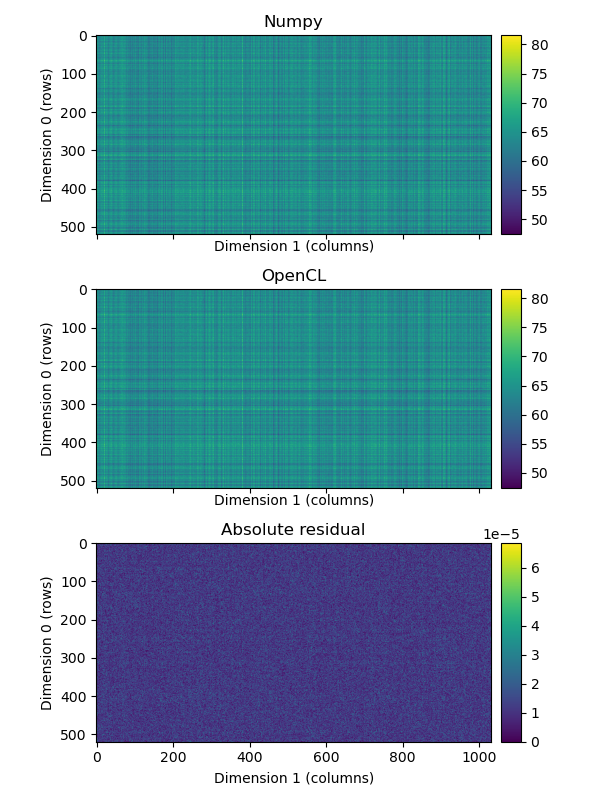

In [6]:
mat_mul.check_data()

### Fine-grained buffer SVM

With fine-grained buffer SVM we can dispense with the explicit mapping and unmapping steps that were necessary in coarse-grained buffer SVM. Synchronisation is guaranteed at points such as **clFinish** or **clWaitForEvents**. In the file [mat_mult_fine_buffer_svm.cpp](mat_mult_fine_buffer_svm.cpp) We check for fine_grained_buffer_SVM using the **CL_DEVICE_SVM_FINE_GRAIN_BUFFER** flag.

```C++
    // mat_mult_fine_buffer_svm.cpp:80
    // Check if the device supports coarse-grained SVM
    cl_device_svm_capabilities svm;
    errcode = clGetDeviceInfo(
        device,
        CL_DEVICE_SVM_CAPABILITIES,
        sizeof(cl_device_svm_capabilities),
        &svm,
        NULL
    );
    
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_FINE_GRAIN_BUFFER)) {
        printf("Device supports fine-grained buffer SVM\n");
    } else {
        printf("Sorry, this device can not support fine-grained buffer SVM\n");
        printf("No solution performed\n");
        exit(OCL_EXIT);
    }
```


Then we allocate SVM memory with the additional **CL_MEM_SVM_FINE_GRAIN_BUFFER** flag.

```C++
    // mat_mult_fine_buffer_svm.cpp:133
    // Allocate SVM memory for array C
    cl_float *array_C = (cl_float*)clSVMAlloc(
        context,
        CL_MEM_WRITE_ONLY | CL_MEM_SVM_FINE_GRAIN_BUFFER,
        nbytes_C,
        0
    );
```

#### Running the example

In [7]:
!make; ./mat_mult_fine_buffer_svm.exe -gpu 0

make: Nothing to be done for 'all'.
	               name: gfx906:sramecc+:xnack- 
	 global memory size: 17163 MB
	    max buffer size: 14588 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
Device supports fine-grained buffer SVM


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
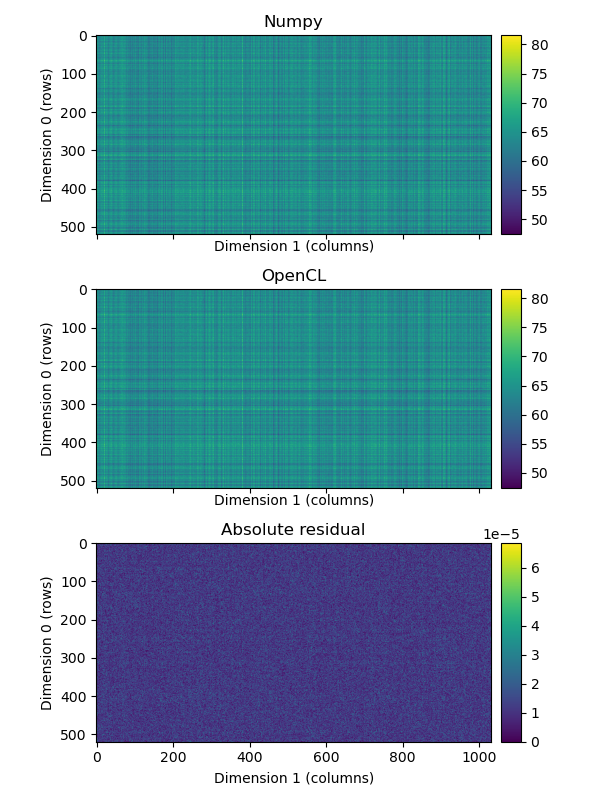

In [8]:
mat_mul.check_data()

### Fine-grained system SVM

With fine-grained system SVM we don't need a call to clSVMAlloc to allocate SVM, nor do we need to create and destroy OpenCL buffers. The source code in [mat_mult_fine_system_svm.cpp](mat_mult_fine_system_svm.cpp) contains the fine system SVM implementation for matrix multiplication. We check for fine-grain system SVM in a similar fashion to fine-grain buffer SVM. 

```C++
    // mat_mult_fine_system_svm.cpp:80

    // Check if the device supports coarse-grained SVM
    cl_device_svm_capabilities svm;
    errcode = clGetDeviceInfo(
        device,
        CL_DEVICE_SVM_CAPABILITIES,
        sizeof(cl_device_svm_capabilities),
        &svm,
        NULL
    );
    
    if (errcode == CL_SUCCESS && 
        (svm & CL_DEVICE_SVM_FINE_GRAIN_SYSTEM)) {
        printf("Device supports fine-grained system SVM\n");
    } else {
        printf("Sorry, this device can not support fine-grained system SVM\n");
        printf("No solution performed\n");
        exit(OCL_EXIT);
    }
```

Any C function, such as **malloc** or **calloc** may be used to then allocate memory for **array_C**, though I prefer aligned memory allocations to eliminate the risk of a memory alignment error.

```C++
    // mat_mult_fine_system_svm.cpp:118

    // Allocate aligned memory for array C
    cl_float *array_C = (cl_float*)h_alloc(N0_C*N1_C*sizeof(cl_float));
```

We can use **array_A**, **array_B**, and **array_C** directly as arguments to the kernel using the [clSetKernelArgSVMPointer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSetKernelArgSVMPointer.html) function.

```C++
    // mat_mult_fine_system_svm.cpp:135

    // Set arguments to the kernel (not thread safe)    
    h_errchk(
        clSetKernelArgSVMPointer(
            kernel, 0, array_A
        ),
        "setting kernel argument 2"
    );
    h_errchk(
        clSetKernelArgSVMPointer(
            kernel, 1, array_B
        ),
        "setting kernel argument 2"
    );
    h_errchk(
        clSetKernelArgSVMPointer(
            kernel, 2, array_C
        ),
        "setting kernel argument 2"
    );
```


In [9]:
!make; ./mat_mult_fine_system_svm.exe -cpu 0

make: Nothing to be done for 'all'.
	               name: AMD Ryzen Threadripper 2950X 16-Core Processor  
	 global memory size: 135049 MB
	    max buffer size: 33762 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Device supports fine-grained system SVM


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
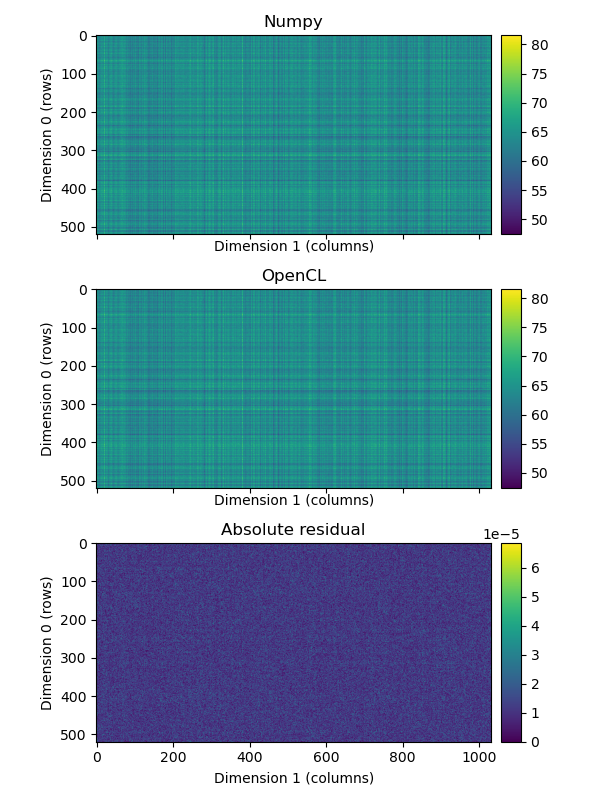

In [10]:
mat_mul.check_data()